In [154]:
import mlflow
import os
import boto3
from io import StringIO
import pandas as pd
import datetime
from datetime import date
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from matplotlib import pyplot

# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster



In [100]:
os.environ["AWS_PROFILE"] = ("mlops") # fill in with your AWS profile. More info: https://docs.aws.amazon.com/sdk-for-java/latest/developer-guide/setup.html#setup-credentials
TRACKING_SERVER_HOST = "ec2-52-17-129-153.eu-west-1.compute.amazonaws.com" # fill in with the public DNS of the EC2 instance
mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:5000")

In [326]:
client = boto3.client('s3')
bucket_name = 'gas-prices-project'

object_key = 'data.csv'
csv_obj = client.get_object(Bucket=bucket_name, Key=object_key)
body = csv_obj['Body']
csv_string = body.read().decode('utf-8')

data = pd.read_csv(StringIO(csv_string))
data

,start_day,end_day,Unleaded 95,Diesel,LPG
0,2022-10-31,2022-11-06,"1,798","2,004","1,031"
1,2022-11-07,2022-11-13,"1,798","2,020","1,033"
2,2022-11-14,2022-11-20,"1,799","2,025","1,036"
3,2022-11-21,2022-11-27,"1,789","2,016","1,037"
4,2022-11-28,2022-12-04,"1,718","1,983","1,033"
...,...,...,...,...,...
163,2021-05-03,2021-05-09,"1,383","1,229","0,723"
164,2021-05-10,2021-05-16,"1,395","1,240","0,723"
165,2021-05-17,2021-05-23,"1,406","1,245","0,724"
166,2021-05-24,2021-05-30,"1,411","1,248","0,725"


In [327]:
data['Diesel'] = data['Diesel'] .str.replace('[A-Za-z]', '').str.replace(',', '.').astype(float)
data['Unleaded 95'] = data['Unleaded 95'] .str.replace('[A-Za-z]', '').str.replace(',', '.').astype(float)
data['LPG'] = data['LPG'] .str.replace('[A-Za-z]', '').str.replace(',', '.').astype(float)
data['start_day'] = pd.to_datetime(data['start_day'],format="%Y-%m-%d")
data['end_day'] = pd.to_datetime(data['end_day'],format="%Y-%m-%d")

C:\Users\saram\AppData\Local\Temp\ipykernel_15376\2408457578.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data['Diesel'] = data['Diesel'] .str.replace('[A-Za-z]', '').str.replace(',', '.').astype(float)
C:\Users\saram\AppData\Local\Temp\ipykernel_15376\2408457578.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data['Unleaded 95'] = data['Unleaded 95'] .str.replace('[A-Za-z]', '').str.replace(',', '.').astype(float)
C:\Users\saram\AppData\Local\Temp\ipykernel_15376\2408457578.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  data['LPG'] = data['LPG'] .str.replace('[A-Za-z]', '').str.replace(',', '.').astype(float)


In [328]:
data['year'] = data['start_day'].dt.year

In [329]:
data.sort_values(by='start_day', inplace = True) 
data.drop_duplicates(data, inplace = True)
data


,start_day,end_day,Unleaded 95,Diesel,LPG,year
157,2019-12-30,2020-01-05,1.349,1.278,0.725,2019
158,2020-01-06,2020-01-12,1.354,1.286,0.725,2020
159,2020-01-13,2020-01-19,1.361,1.295,0.725,2020
160,2020-01-20,2020-01-26,1.361,1.292,0.724,2020
153,2020-01-27,2020-02-02,1.351,1.277,0.724,2020
...,...,...,...,...,...,...
13,2023-01-30,2023-02-05,1.699,1.745,0.999,2023
24,2023-02-06,2023-02-12,1.683,1.744,0.999,2023
25,2023-02-13,2023-02-19,1.665,1.744,0.999,2023
26,2023-02-20,2023-02-26,1.657,1.732,0.997,2023


In [330]:
data = data[~(data['start_day'] > pd.to_datetime(date.today()) )]
data_ts = data[['start_day', 'Diesel']]
data_ts = data_ts.set_index('start_day')
data_ts.index = pd.to_datetime(data_ts.index)
data_ts.sort_values(by='start_day', inplace = True) 
data_ts = data_ts.sort_index().asfreq(freq='W-MON')
data_ts 
#print(pd.infer_freq(test.index))


,Diesel
start_day,
2019-12-30,1.278
2020-01-06,1.286
2020-01-13,1.295
2020-01-20,1.292
2020-01-27,1.277
...,...
2023-01-30,1.745
2023-02-06,1.744
2023-02-13,1.744


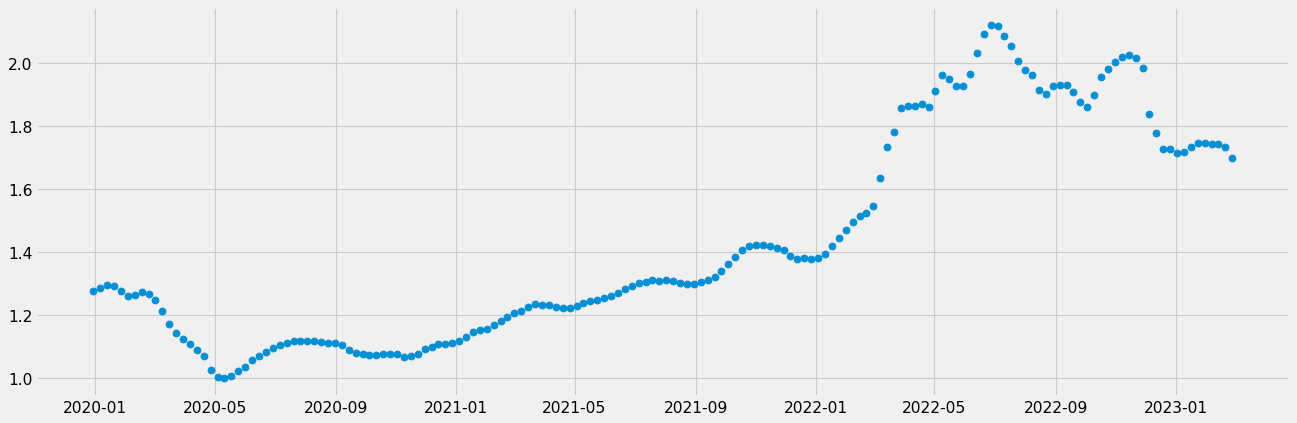

In [332]:
figure(figsize=(18, 6), dpi=80)
plt.plot_date(data['start_day'], data['Diesel'])

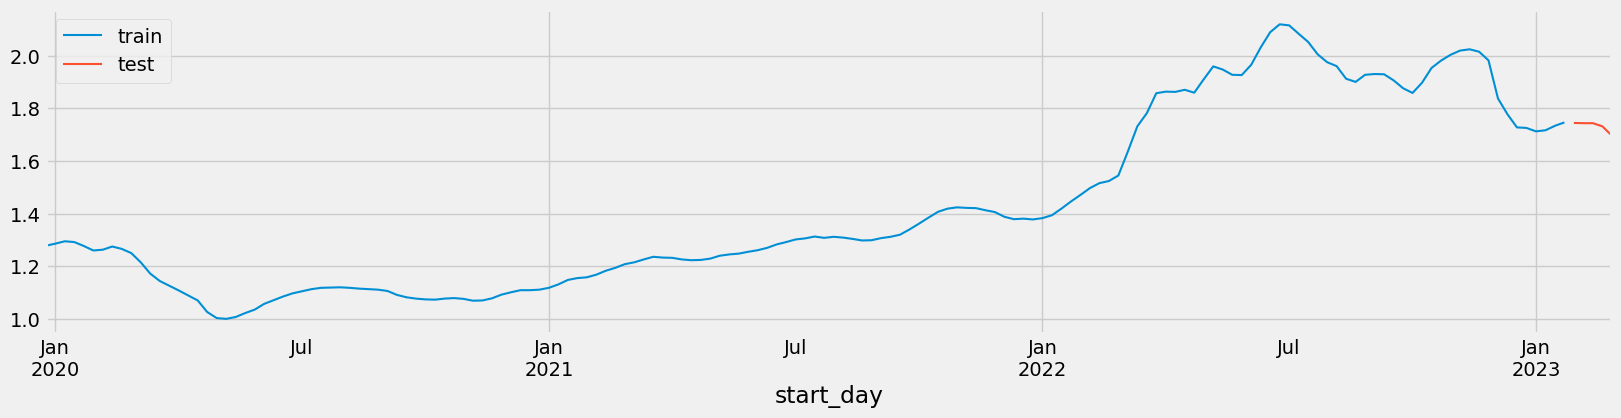

In [337]:
steps = 5
data_train = data_ts[:-steps]
data_test  = data_ts[-steps:]
fig, ax=plt.subplots(figsize=(18, 4))
data_train['Diesel'].plot(ax=ax, label='train')
data_test['Diesel'].plot(ax=ax, label='test')
ax.legend();

In [338]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 7
             )

forecaster.fit(y=data_train['Diesel'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6 7] 
Transformer for y: None 
Transformer for exog: None 
Window size: 7 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2019-12-30 00:00:00'), Timestamp('2023-01-23 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: W-MON 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-03-09 10:47:01 
Last fit date: 2023-03-09 10:47:01 
Skforecast version: 0.6.0 
Python version: 3.9.4 

In [341]:
# Predictions
# ==============================================================================
steps = 5
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2023-01-30    1.75859
2023-02-06    1.78448
2023-02-13    1.82073
2023-02-20    1.82691
2023-02-27    1.82883
Freq: W-MON, Name: pred, dtype: float64

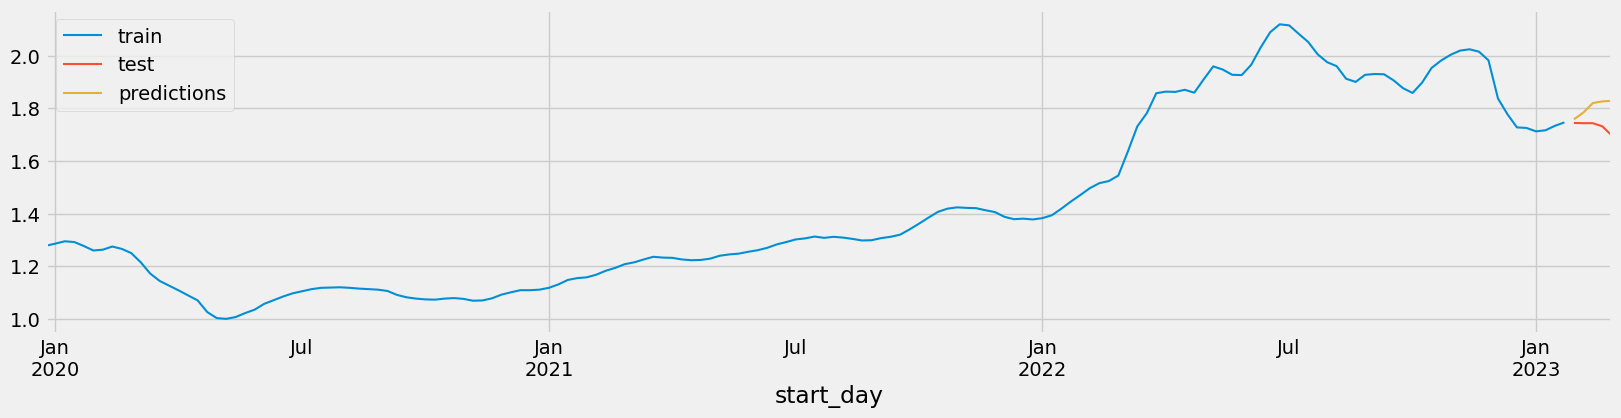

In [342]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(18, 4))
data_train['Diesel'].plot(ax=ax, label='train')
data_test['Diesel'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [84]:
TRACKING_SERVER_HOST = "ec2-52-17-129-153.eu-west-1.compute.amazonaws.com" # fill in with the public DNS of the EC2 instance
mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:5000")

In [85]:
print(f"tracking URI: '{mlflow.get_tracking_uri()}'")


tracking URI: 'http://ec2-52-17-129-153.eu-west-1.compute.amazonaws.com:5000'
